In [ ]:
import tensorflow as tf


# Check tensorflow version
print("Using Tensorflow %s\n" % (tf.__version__))

Using Tensorflow 2.7.0



In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn import metrics
import math
import numpy as np
import cv2
from tensorflow.keras.models import Model

In [ ]:
pixels = 500

In [ ]:
from tensorflow import keras
model = keras.models.load_model("/content/gdrive/MyDrive/stanford40IterationwithoutVal.h5")

YoloModel = keras.models.load_model("/content/gdrive/MyDrive/YoloModel.h5")


In [ ]:
# model.summary()

In [ ]:
# YoloModel.summary()

**Yolo Pipeline**

In [ ]:
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height

In [ ]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    
    return self.label
  
  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.get_score

def _sigmoid(x):
  return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores


In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

HARLabels = ["applauding", "blowing_bubbles", "brushing_teeth", "cleaning_the_floor", "climbing",
               "cooking", "cutting_trees", "cutting_vegetables", "drinking", "feeding_a_horse", "fishing",
               "fixing_a_bike","fixing_a_car", "gardening", "holding_an_umbrella", "jumping", "looking_through_a_microscope",
               "looking_through_a_telescope", "phoning", "playing_guitar", "playing_violin", "pouring_liquid", "pushing_a_cart",
               "reading", "riding_a_bike", "riding_a_horse", "rowing_a_boat", "running", "shooting_an_arrow", "smoking", "taking_photos",
               "texting_message", "throwing_frisby", "using_a_computer", "walking_the_dog", "washing_dishes", "watching_TV", "waving_hands",
               "writing_on_a_board", "writing_on_a_book"]

In [ ]:
  from google.colab.patches import cv2_imshow

  def draw_boxesV2(filename, v_boxes, v_labels, v_scores):

    img = cv2.imread(filename)
    print(img.shape)

    for i in range(len(v_boxes)):
      box = v_boxes[i]
      y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
      width, height = x2 - x1, y2 - y1
      if v_labels[i] == "person":
        cropped_img = img[y1:y2,x1:x2]
        cv2_imshow(cropped_img)

        classify_image(cropped_img)


**HAR Pipeline**

In [ ]:
from numpy import expand_dims
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  width, height = image.size

  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height

In [ ]:
def classify_image(image):

  # define the expected input shape for the model
  input_w, input_h = pixels, pixels

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # make prediction
  yhat = model.predict(image)

  #print(cam.shape)
  print(yhat.shape)
  category = np.argmax(yhat)
  print(category)
  print(HARLabels[category])
  


Saving applauding_002.jpg to applauding_002 (1).jpg
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
person 99.36466813087463
person 99.15450811386108
person 99.97708201408386
diningtable 65.94471335411072
cup 69.70720291137695
cup 99.59636926651001
cup 69.42440271377563
cup 65.04261493682861
cup 76.12927556037903
(300, 421, 3)


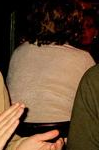

(1, 40)
37
waving_hands


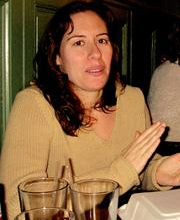

(1, 40)
37
waving_hands


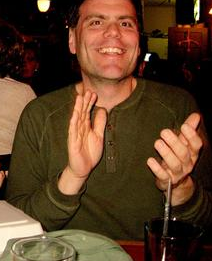

(1, 40)
37
waving_hands


In [ ]:
from google.colab import files 
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # define the expected input shape for the model
  input_w, input_h = 416, 416

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # make prediction
  yhat = YoloModel.predict(image)
  # summarize the shape of the list of arrays
  print([a.shape for a in yhat])
  
  boxes = list() 
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
 
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # summarize what we found
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
  
  # draw what we found
  draw_boxesV2(photo_filename, v_boxes, v_labels, v_scores)